# Data for Good: predicting suicidal behavior likelihood using Deep Learning (Part 4)

*Deep Learning and Reinforcement Learning (part of IBM Machine Learning Professional Certificate) - Course Project.*

>*Happiness can be found, even in the darkest of times, if one only remembers to turn on the light.*  
― **J.K. Rowling, Harry Potter and the Prisoner of Azkaban**

## Table of contents (Part 4)
5. [Model Development: Recurrent Neural Networks](#model)  
  5.4. [Recurrent Neural Network with Regularization Techniques](#regularized)
6. [Results](#results)  
  6.1. [Non-regularized model](#nonreg)  
  6.2. [Regularized model](#reg)  
  6.3. [Moving the discrimination threshold](#thresholding)  
7. [Discussion](#discussion)  
8. [Conclusion](#conclusion)  
  8.1. [Project Summary](#summary)  
  8.2. [Outcome of the Analysis](#outcome)  
  8.3. [Potential Developments](#developments)

*Import the training data, the testing data, and the vocabulary word index from the 1st part of the project.*

In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
x_train_pad = pd.read_csv('x_train_pad.csv', index_col=False).values
x_test_pad = pd.read_csv('x_test_pad.csv', index_col=False).values
y_train = pd.read_csv('y_train.csv', index_col=False)
y_test = pd.read_csv('y_test.csv', index_col=False)

In [3]:
with open('word_index.pkl', 'rb') as f:
    word_index = pickle.load(f)

## 5. Model Development: Recurrent Neural Networks <a name= 'model'></a>

In [4]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Embedding
from keras import optimizers
from numpy.random import seed
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.constraints import max_norm
from keras.callbacks import ModelCheckpoint

### 5.4. Recurrent Neural Network with Regularization Techniques <a name='regularized'></a>

Learning the word embeddings from scratch proved to be the best option in terms of model's accuracy, calculated on unseen data.  
All trained models, however, have a common issue: the overfitting. All networks, regardless of the used word embeddings, fits the training data very well, achieving 100% training accuracy after few epochs; however, the accuracy calculated on the validation set, seems unable to exceed the 65% threshold:
- Learn the word embeddings from scratch: 65% accuracy
- Pre-trained GloVe Word Embeddings: 64% accuracy
- Pre-trained Google News Word2Vec Word Embeddings: 60% accuracy

I'll try to increase the out-of-sample accuracy by building a last model: learning the word embeddings from scratch and using some **regularization techniques**, in order to decrease the variance of the model.  
Regularization techniques should lead to a "simpler" model, where the predictions are less sensitive to changes in the input data, and so, hopefully, increase the ability of the model to "generalize" better when making predictions, that is to better capture the underlying relationships between the target and the predictor, without following too much the noise present in the training data; this will, almost certainly, lead to a lower training accuracy, but the hope is that the validation accuracy will increase.  
I'll use the following regularization techniques:
- **L2 Regularization Penalty** for the Embedding and the Recurrent Neural Network layers. This means that the sum of the squares of the parameters (for the Recurrent Neural Network, the penalty is considered for both the bias, the Kernel, and the Recurrent weights) will be added to the model loss, thus forcing the model to keep the parameter values smaller (and so reducing the sensitivity to the input data).
- Using the **Keras constraint Max Norm** for all model layers. The Max Norm constraint forces the model weights to have a magnitude less than or equal to a certain value, which will be set to 1 for all layers.

In [5]:
seed(1)
tf.random.set_seed(1)

#Initialize the model
reg_rnn = Sequential()
reg_rnn.add(Embedding(len(word_index.items())+1, output_dim=300, trainable=True, embeddings_regularizer='l2',
                      embeddings_constraint=max_norm(1)))

reg_rnn.add(SimpleRNN(units=150, activation='tanh', input_shape=x_train_pad.shape[1:], kernel_regularizer='l2',
                      recurrent_regularizer='l2', bias_regularizer='l2', kernel_constraint=max_norm(1),
                      recurrent_constraint=max_norm(1), bias_constraint=max_norm(1)))

reg_rnn.add(Dense(1, activation='sigmoid', kernel_constraint=max_norm(1), bias_constraint=max_norm(1)))

adam = optimizers.Adam(learning_rate=0.001)
reg_rnn.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

reg_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4726500   
                                                                 
 simple_rnn (SimpleRNN)      (None, 150)               67650     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 4,794,301
Trainable params: 4,794,301
Non-trainable params: 0
_________________________________________________________________


The number of parameters is unchanged.

In [6]:
#set Keras Model Checkpoint callback to save the weights when the model is at its best performance
mcp=ModelCheckpoint('reg_best_weights.hdf5', monitor="val_accuracy", mode='max', save_best_only=True, save_weights_only=True,
                    save_freq="epoch")

hist=reg_rnn.fit(x_train_pad, y_train, batch_size=16, epochs=25, shuffle=True, validation_data=(x_test_pad, y_test),
                 callbacks=[mcp])

Epoch 1/25
25/25 [==============================] - 7s 159ms/step - loss: 5.5910 - accuracy: 0.5675 - val_loss: 2.8658 - val_accuracy: 0.6100
Epoch 2/25
25/25 [==============================] - 3s 135ms/step - loss: 2.4327 - accuracy: 0.7275 - val_loss: 2.0865 - val_accuracy: 0.5900
Epoch 3/25
25/25 [==============================] - 4s 141ms/step - loss: 1.8353 - accuracy: 0.6600 - val_loss: 1.6587 - val_accuracy: 0.5900
Epoch 4/25
25/25 [==============================] - 4s 143ms/step - loss: 1.5254 - accuracy: 0.5900 - val_loss: 1.4928 - val_accuracy: 0.5900
Epoch 5/25
25/25 [==============================] - 4s 158ms/step - loss: 1.3717 - accuracy: 0.5850 - val_loss: 1.2921 - val_accuracy: 0.5900
Epoch 6/25
25/25 [==============================] - 4s 145ms/step - loss: 1.1976 - accuracy: 0.5850 - val_loss: 1.1630 - val_accuracy: 0.5900
Epoch 7/25
25/25 [==============================] - 4s 152ms/step - loss: 1.1077 - accuracy: 0.6075 - val_loss: 1.1917 - val_accuracy: 0.5700
Epoch 

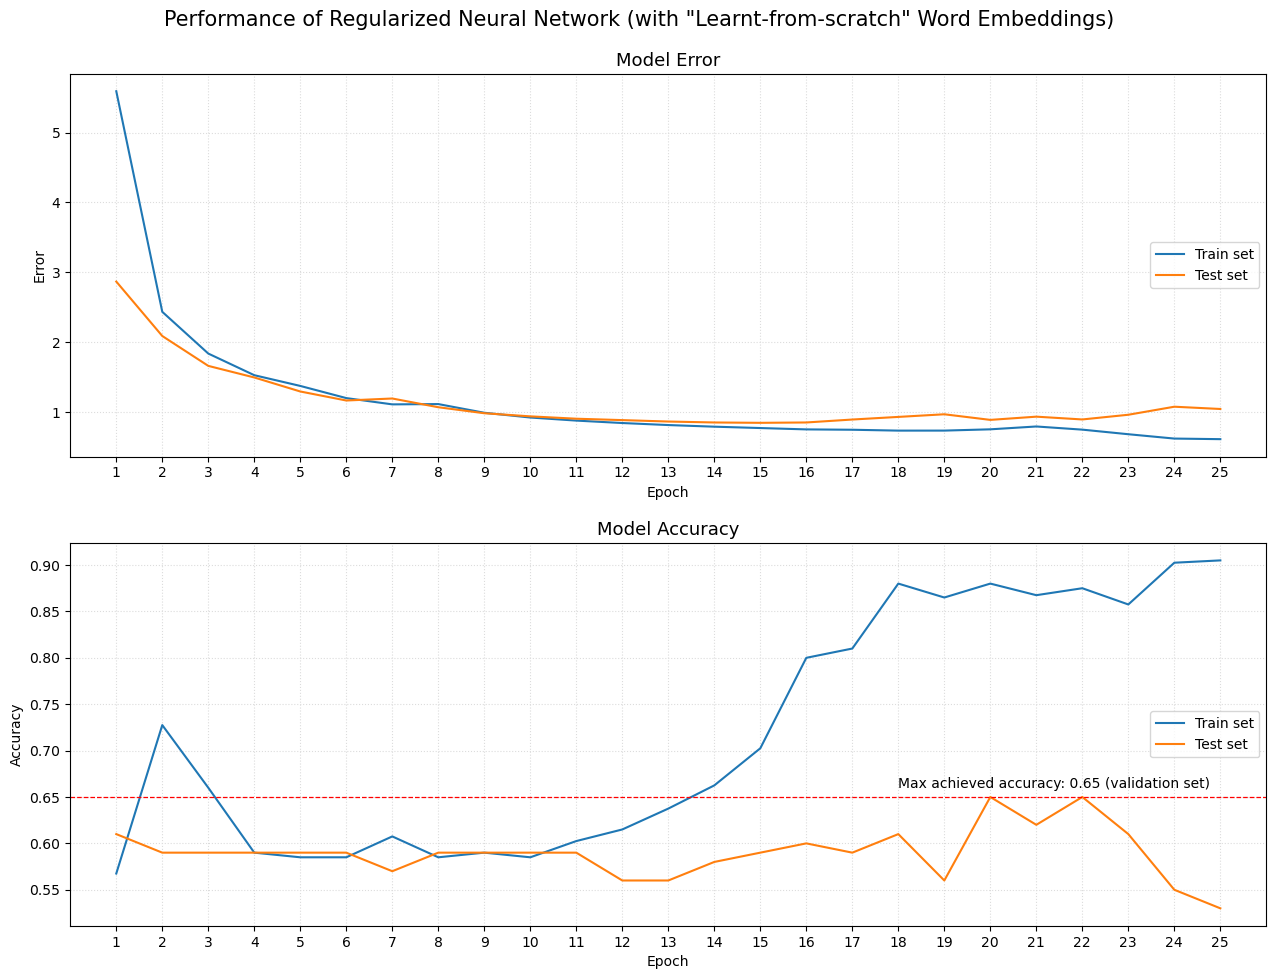

In [7]:
fig = plt.figure(figsize=(13,10))
loss = fig.add_subplot(2,1,1) 
accuracy = fig.add_subplot(2,1,2)

accuracy.plot(hist.history['accuracy'])
accuracy.plot(hist.history['val_accuracy'])
accuracy.set_title('Model Accuracy', fontsize=13)
accuracy.set_ylabel('Accuracy')
accuracy.set_xlabel('Epoch')
accuracy.set_xticks(range(0,25))
accuracy.set_xticklabels(range(1,26))
accuracy.set_xlim(-1,25)
accuracy.legend(['Train set', 'Test set'], loc='center right')
accuracy.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)
accuracy.axhline(y=0.65, color='r', lw=0.9, ls='--')
accuracy.annotate('Max achieved accuracy: 0.65 (validation set)', xy=(17,0.66))

loss.plot(hist.history['loss'])
loss.plot(hist.history['val_loss'])
loss.set_title('Model Error', fontsize=13)
loss.set_ylabel('Error')
loss.set_xlabel('Epoch')
loss.set_xticks(range(0,25))
loss.set_xticklabels(range(1,26))
loss.set_xlim(-1,25)
loss.legend(['Train set', 'Test set'], loc='center right')
loss.grid(True, axis='both', color='gainsboro', ls= ':', linewidth=0.8)

plt.suptitle('Performance of Regularized Neural Network (with "Learnt-from-scratch" Word Embeddings)', fontsize=15)
plt.tight_layout(pad=1.5)
plt.show()

Some remarks:
- The model achieved, again, a max accuracy of 65%, after 20 epochs. Even regularized model couldn't exceed that threshold, and it took longer for the regularized model to achieve that maximum value.
- As expected, the training accuracy is less than when not using regularization techniques. On the 20th epoch, that is when the model achieved the best result, the training accuracy is equal to 88%.

In [8]:
reg_rnn.load_weights('reg_best_weights.hdf5')
print("Best Accuracy achieved on validation data:", round(reg_rnn.evaluate(x_test_pad, y_test)[1],2))

4/4 [==============================] - 0s 40ms/step - loss: 0.8856 - accuracy: 0.6500
Best Accuracy achieved on validation data: 0.65


Since both regularized and non-regularized model achieved the same result, I'll compare the model's predictions (on unseen data) and performance, using other evaluation metrics other then the accuracy, to check for differences and eventually decide what model performed better. 

## 6. Results <a name='results'></a>

In [9]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, precision_recall_curve, f1_score, auc,\
roc_auc_score
import itertools

### 6.1. Non-regularized model <a name='nonreg'></a>

In [10]:
#load the non-regularized model's predictions from the project part 1
with open('ypred.pkl', 'rb') as f:
    ypred = pickle.load(f)

In [11]:
#assigning the classes by applying the "default" probability threshold of 50%
ypred_class = (ypred >= .5).astype('int')
ypred_class[0:5]

array([[1],
       [1],
       [0],
       [1],
       [1]])

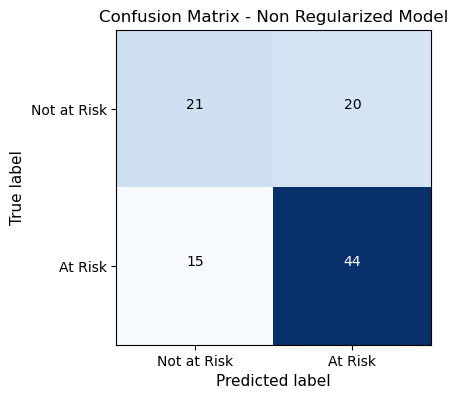

In [12]:
#Define a function for better visualization of Confusion Matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, ax=plt.gca):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=11)
    plt.xlabel('Predicted label', fontsize=11)
    plt.tight_layout()
    

rnn_cm = confusion_matrix(y_test, ypred_class, labels=[0,1])
plt.figure(figsize=(4.5,4.5))
plot_confusion_matrix(rnn_cm, classes=['Not at Risk', 'At Risk'], title='Confusion Matrix - Non Regularized Model')
plt.show()

In [13]:
print('Classification Report - Non Regularized Model')
print(classification_report(y_test, ypred_class, labels=[0,1], target_names=['Not at Risk', 'At Risk']))
#print('ROC - Area Under the Curve: ', round(roc_auc_score(y_test, ypred),2))

Classification Report - Non Regularized Model
              precision    recall  f1-score   support

 Not at Risk       0.58      0.51      0.55        41
     At Risk       0.69      0.75      0.72        59

    accuracy                           0.65       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.64      0.65      0.65       100



Remarks:
- The model did a decent job at correctly predicting the users belonging to the positive class, with a Sensitivity (the recall on the positive class) of 75%: 3 out of 4 users "At Risk" of self-harm have been correctly classified.
- The Specificity (the recall on the negative class) is not very high though: 51%; only 1 out of 2 "Not-at-Risk" users were correctly classified.
- Overall the model struggles to identify the "Not-at-Risk" users, and achieved an overall F1 Score (the weighted average of each class Precision and Recall harmonic average) of 65%.

### 6.2. Regularized model <a name='reg'></a>

In [14]:
#output predictions, on unseen data, for the regularized model
reg_ypred = reg_rnn.predict(x_test_pad)
reg_ypred_class = (reg_ypred >= .5).astype('int')

4/4 [==============================] - 0s 26ms/step


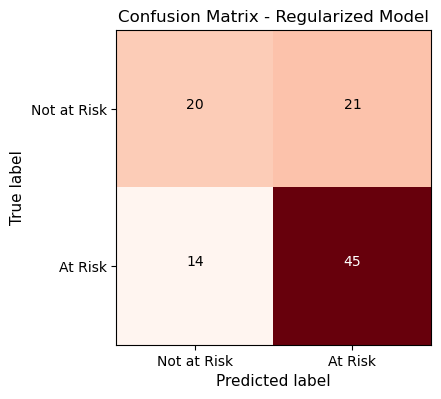

In [15]:
reg_rnn_cm = confusion_matrix(y_test, reg_ypred_class, labels=[0,1])

plt.figure(figsize=(4.5,4.5))
plot_confusion_matrix(reg_rnn_cm, classes=['Not at Risk', 'At Risk'], title='Confusion Matrix - Regularized Model',
                      cmap=plt.cm.Reds)
plt.show()

In [16]:
print('Classification Report - Regularized Model')
print(classification_report(y_test, reg_ypred_class, labels=[0,1], target_names=['Not at Risk', 'At Risk']))
#print('ROC - Area Under the Curve: ', round(roc_auc_score(y_test, reg_ypred),2))

Classification Report - Regularized Model
              precision    recall  f1-score   support

 Not at Risk       0.59      0.49      0.53        41
     At Risk       0.68      0.76      0.72        59

    accuracy                           0.65       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.64      0.65      0.64       100



Remarks:
- The performance of the regularized model is very similar to the non-regularized one, with the network still struggling to identify the "Not-at-Risk" users.
- The regularized model predicted 2 more users as "At Risk", compared to the non-regularized model, 1 correctly and 1 not correctly; this led to a higher Sensitivity (the recall on the positive class or the True Positive Rate), but a lower Specifity (the recall on the negative class), so the False Postive Rate also increased (thus reducing the precision of the positive class predictions).
- Overall the regularized model achieved an overall F1 Score of 64%, slightly less than the non-regularized model.

### 6.3. Moving the discrimination threshold <a name='thresholding'></a>

The performance of the 2 models is very similar, and they both struggle with a high False Positive Rate ("not-at-risk" users predicted as "at risk"), which is around 50%.  
However, the networks output the probabilities of the observations to belong to the positive class, and not directly the class values. I inferred the class value by applying the "default" probability threshold of 50%, that is if an example has a predicted probability of belonging to the positive class equal or greater than 50%, it'll be classified as "at-risk"; if less than 50%, then "not at risk". I'll try to calibrate this probability threshold, to either decrease the number of false positive or the number of false negatives.  
To look for the best probability threshold for both the regularized and non-regularized model, I'll use the Receiver Operating Characteristic (ROC) as well as the Precision-Recall curves:
- **Receiver Operating Characteristic (ROC) curve:** a graphical plot that illustrates the diagnostic ability of a binary classifier as its discrimination threshold is varied. The ROC curve is created by plotting the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.
- **Precision-Recall curve:** a graphical plot that shows the tradeoff between precision and recall for different probability thresholds. A high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

To find out the best decision threshold, I'll calculate the best trade off between:
- The True Positive Rate and the False Positive Rate, using as metric the **Youden’s J statistic** (which is the difference between the True Positive Rate and the False Positive Rate).  
- the Precision and Recall of the positive class, using as metric the **F1 Score** (the harmonic mean between Precision and Recall).

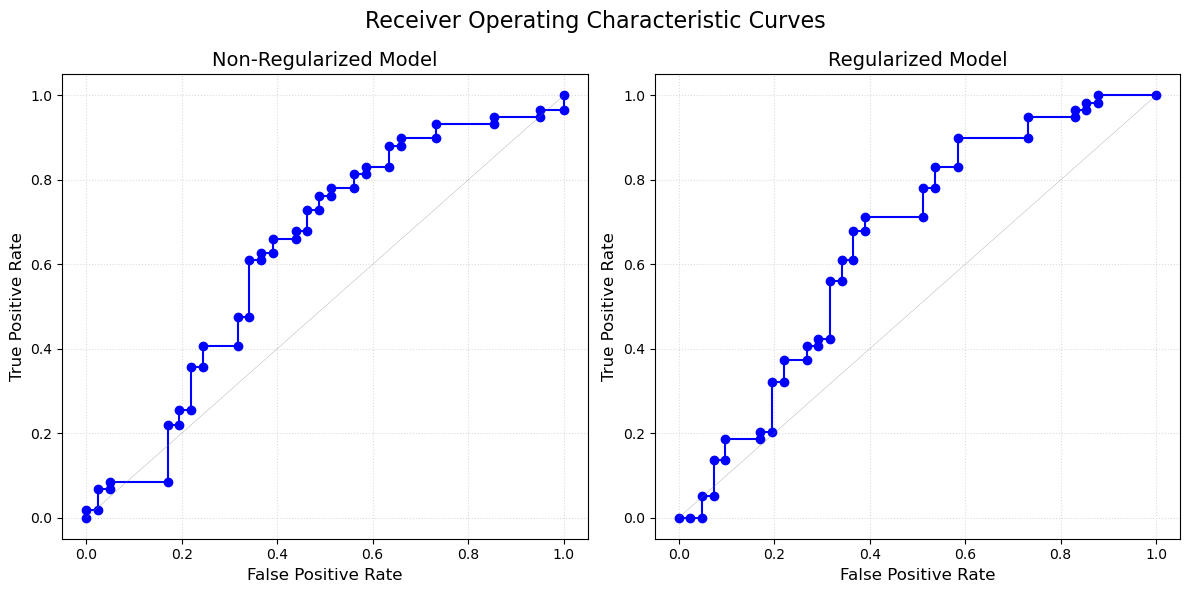

In [17]:
# plot ROC curves curves for both models 
fpr, tpr, thresholds = roc_curve(y_test, ypred)
reg_fpr, reg_tpr, reg_thresholds = roc_curve(y_test, reg_ypred)

fig, ax_list = plt.subplots(1, 2, figsize=(12,6))
ax1 = ax_list[0]
ax1.plot(fpr, tpr, marker='o', color='blue')
ax1.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='gray', lw=0.2)
ax1.set_title('Non-Regularized Model', fontsize=14)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate',fontsize=12)
ax1.grid(True, ls= ':', linewidth=0.8, color='gainsboro')

ax2 = ax_list[1]
ax2.plot(reg_fpr, reg_tpr, marker='o', color='blue')
ax2.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='gray', lw=0.2)
ax2.set_title('Regularized Model', fontsize=14)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate',fontsize=12)
ax2.grid(True, ls= ':', linewidth=0.8, color='gainsboro')

plt.suptitle('Receiver Operating Characteristic Curves', fontsize=16)
plt.tight_layout()
plt.show()

In [18]:
print('ROC Area Under the Curve - Non-Regularized Model: ', round(roc_auc_score(y_test, ypred),2))
print('ROC Area Under the Curve - Regularized Model:', round(roc_auc_score(y_test, reg_ypred),2))

ROC Area Under the Curve - Non-Regularized Model:  0.63
ROC Area Under the Curve - Regularized Model: 0.65


Both models are above the line of random guessing for almost every threshold, with an overall Area Under the Curve slightly greater for the regularized model (0.65 vs 0.63).  
Let's look now for the best threshold.

In [19]:
#non-regularized model
j_stat = []
for t in range(thresholds.shape[0]):
    j_stat.append(tpr[t] - fpr[t])

best_j_idx = j_stat.index(max(j_stat))
print("Non-Regularized Model - Best threshold: {}; Youden's J statistic: {}.".format(thresholds[best_j_idx], max(j_stat)))

Non-Regularized Model - Best threshold: 0.4570866525173187; Youden's J statistic: 0.27490698635799915.


In [20]:
#regularized model
reg_j_stat = []
for t in range(reg_thresholds.shape[0]):
    reg_j_stat.append(reg_tpr[t] - reg_fpr[t])

reg_best_j_idx = reg_j_stat.index(max(reg_j_stat))
print("Regularized Model - Best threshold: {}; Youden's J statistic: {}.".format(reg_thresholds[reg_best_j_idx],
                                                                                 max(reg_j_stat)))

Regularized Model - Best threshold: 0.5387617349624634; Youden's J statistic: 0.3216205043406366.


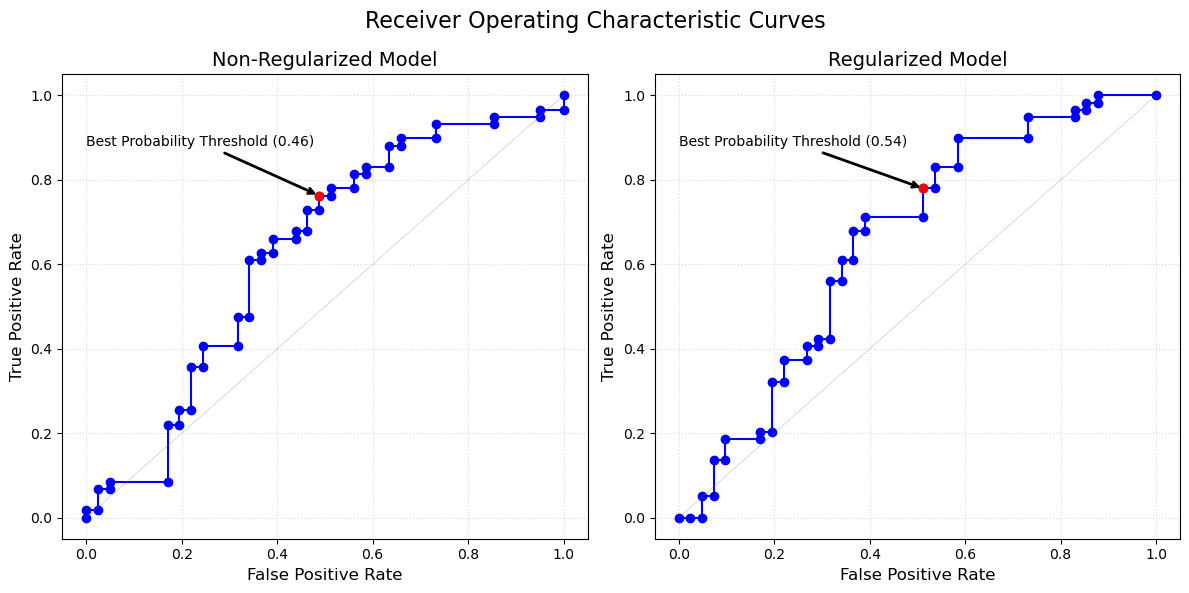

In [21]:
fig, ax_list = plt.subplots(1, 2, figsize=(12,6))
ax1 = ax_list[0]
ax1.plot(fpr, tpr, marker='o', color='blue')
ax1.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='gray', lw=0.2)
ax1.set_title('Non-Regularized Model', fontsize=14)
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate',fontsize=12)
ax1.grid(True, ls= ':', linewidth=0.8, color='gainsboro')
ax1.plot(fpr[best_j_idx], tpr[best_j_idx], marker='o', color='red')
ax1.annotate('Best Probability Threshold (0.46)',
            xy=(fpr[best_j_idx], tpr[best_j_idx]),
            xytext=(0,0.88),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black', lw=2))

ax2 = ax_list[1]
ax2.plot(reg_fpr, reg_tpr, marker='o', color='blue')
ax2.plot(np.linspace(0,1,100), np.linspace(0,1,100), color='gray', lw=0.2)
ax2.set_title('Regularized Model', fontsize=14)
ax2.set_xlabel('False Positive Rate', fontsize=12)
ax2.set_ylabel('True Positive Rate',fontsize=12)
ax2.grid(True, ls= ':', linewidth=0.8, color='gainsboro')
ax2.plot(reg_fpr[best_j_idx], reg_tpr[best_j_idx], marker='o', color='red')
ax2.annotate('Best Probability Threshold (0.54)',
            xy=(reg_fpr[best_j_idx], reg_tpr[best_j_idx]),
            xytext=(0,0.88),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black', lw=2))

plt.suptitle('Receiver Operating Characteristic Curves', fontsize=16)
plt.tight_layout()
plt.show()

In [22]:
ypred_class_1 = (ypred >= thresholds[best_j_idx]).astype('int')

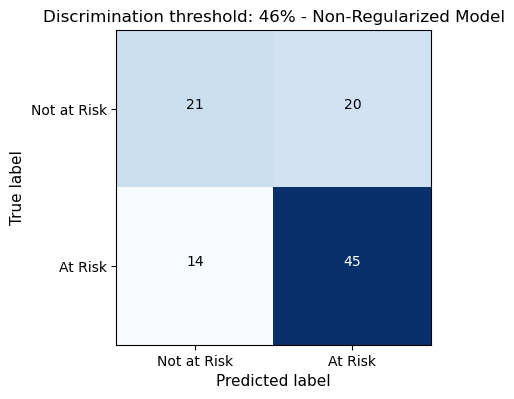

In [23]:
rnn_cm_1 = confusion_matrix(y_test, ypred_class_1, labels=[0,1])

plt.figure(figsize=(4.5,4.5))
plot_confusion_matrix(rnn_cm_1, classes=['Not at Risk','At Risk'],title='Discrimination threshold: 46% - Non-Regularized Model')
plt.show()

In [24]:
print('Discrimination Threshold: 46% - Non-Regularized Model Classification Report')
print(classification_report(y_test, ypred_class_1, labels=[0,1], target_names=['Not at Risk', 'At Risk']))

Discrimination Threshold: 46% - Non-Regularized Model Classification Report
              precision    recall  f1-score   support

 Not at Risk       0.60      0.51      0.55        41
     At Risk       0.69      0.76      0.73        59

    accuracy                           0.66       100
   macro avg       0.65      0.64      0.64       100
weighted avg       0.65      0.66      0.65       100



In [25]:
print('Discrimination Threshold: 50% - Non-Regularized Model Classification Report')
print(classification_report(y_test, ypred_class, labels=[0,1], target_names=['Not at Risk', 'At Risk']))

Discrimination Threshold: 50% - Non-Regularized Model Classification Report
              precision    recall  f1-score   support

 Not at Risk       0.58      0.51      0.55        41
     At Risk       0.69      0.75      0.72        59

    accuracy                           0.65       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.64      0.65      0.65       100



Applying a discrimation threshold equal to 46% (as in to make it slightly easier for the model to predict users belonging to the positive class) on the Non-regularized model produced better results (compared to the 50% threshold):
- the model sensitivity, that is the True Positive Rate, increased from 75% to 76%, without negatively affecting any oother metrics: the model managed to correctly predict one more user classifed as "At Risk", keeping the same specificity (or True Negative Rate).
- The model precision, on the Negative Class, also increased (from 58% to 60%)  as well as the F1 Score (Macro Average: from 63% to 64%) and the overall accuracy, from 65% to 66%.

---

In [26]:
reg_ypred_class_1 = (reg_ypred >= reg_thresholds[reg_best_j_idx]).astype('int')

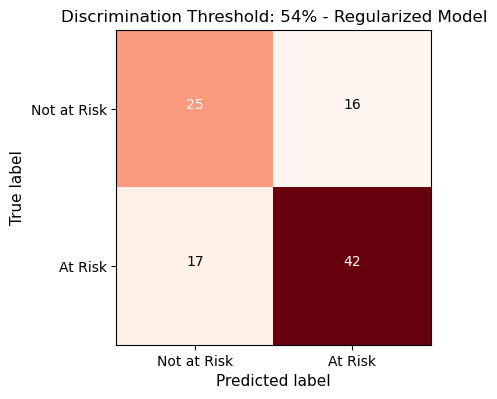

In [27]:
reg_rnn_cm_1 = confusion_matrix(y_test, reg_ypred_class_1, labels=[0,1])

plt.figure(figsize=(4.5,4.5))
plot_confusion_matrix(reg_rnn_cm_1, classes=['Not at Risk', 'At Risk'],
                      title='Discrimination Threshold: 54% - Regularized Model', cmap=plt.cm.Reds)
plt.show()

In [28]:
print('Discrimination Threshold: 54% - Regularized Model Classification Report')
print(classification_report(y_test, reg_ypred_class_1, labels=[0,1], target_names=['Not at Risk', 'At Risk']))

Discrimination Threshold: 54% - Regularized Model Classification Report
              precision    recall  f1-score   support

 Not at Risk       0.60      0.61      0.60        41
     At Risk       0.72      0.71      0.72        59

    accuracy                           0.67       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.67      0.67      0.67       100



In [29]:
print('Discrimination Threshold: 50% - Regularized Model Classification Report')
print(classification_report(y_test, reg_ypred_class, labels=[0,1], target_names=['Not at Risk', 'At Risk']))

Discrimination Threshold: 50% - Regularized Model Classification Report
              precision    recall  f1-score   support

 Not at Risk       0.59      0.49      0.53        41
     At Risk       0.68      0.76      0.72        59

    accuracy                           0.65       100
   macro avg       0.64      0.63      0.63       100
weighted avg       0.64      0.65      0.64       100



Applying a discrimination threshold equal to 54% (as in to make it slightly more difficult for the model to predict users belonging to the positive class) on the Regularized model produced a more accurate algorithm, with one drawback:
- The model specificity increased from 49% to 61%: the model is now able to predict way more accurately users that are "Not-At-Risk".
- Overall the model precison increased for both classes, from 59% to 60% for the Negative Class, and from 68% to 72% for the Positive Class leading to a better F1 Score (weighted average: from 64% to 67%) and Accuracy: from 65% to 67%.
- However, the model sensitivity decreased from 76% to 71%; the model has indeed become more accurate, but it has now more difficulty predicting the users "at-risk", which is the main purpose of this model, since these users are the ones that need help.

---

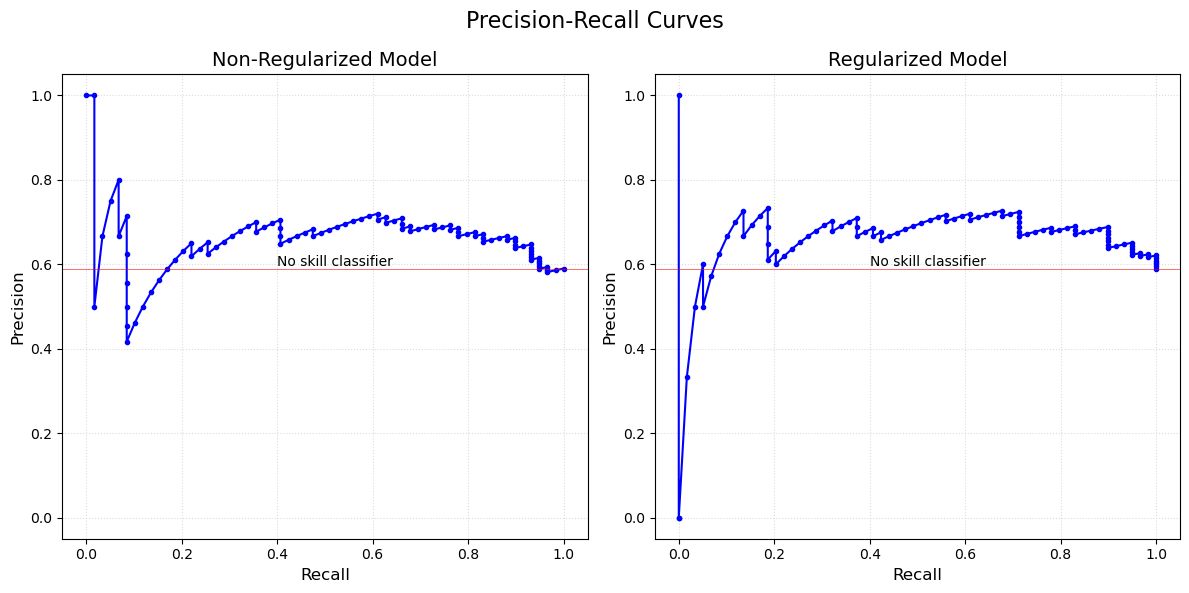

In [30]:
# plot ROC curve and Precision/Recall curves for both models 
precision, recall, pr_thresholds = precision_recall_curve(y_test, ypred)
reg_precision, reg_recall, reg_pr_thresholds = precision_recall_curve(y_test, reg_ypred)

fig, ax_list = plt.subplots(1, 2, figsize=(12,6))
ax1 = ax_list[0]
ax1.plot(recall, precision, marker='.', color='blue')
ax1.axhline(y=y_test[y_test==1].sum().tolist()[0]/len(y_test), color='red', lw=0.4, ls='-')
ax1.annotate('No skill classifier', xy=(0.4,(y_test[y_test==1].sum()/len(y_test))+0.005))
ax1.set_title('Non-Regularized Model', fontsize=14)
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision',fontsize=12)
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, ls= ':', linewidth=0.8, color='gainsboro')

ax2 = ax_list[1]
ax2.plot(reg_recall, reg_precision, marker='.', color='blue')
ax2.axhline(y=y_test[y_test==1].sum().tolist()[0]/len(y_test), color='red', lw=0.4, ls='-')
ax2.annotate('No skill classifier', xy=(0.4,(y_test[y_test==1].sum()/len(y_test))+0.005))
ax2.set_title('Regularized Model', fontsize=14)
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision',fontsize=12)
ax2.grid(True, ls= ':', linewidth=0.8, color='gainsboro')

plt.suptitle('Precision-Recall Curves', fontsize=16)
plt.tight_layout()
plt.show()

In [31]:
print('Precision-Recall Area Under the Curve - Non-regularized model: ', round(auc(recall, precision),2))
print('Precision-Recall Area Under the Curve - Regularized model: ', round(auc(reg_recall, reg_precision),2))

Precision-Recall Area Under the Curve - Non-regularized model:  0.66
Precision-Recall Area Under the Curve - Regularized model:  0.66


Both models are above the line of "No-Skill Classifier" (that is the precision we would get if the model predicted all observations as members of the positive class) for the vast majority of the threshold, with an overall Area Under the Curve of 66% for both models.  
Let's look now for the best threshold

In [32]:
#non-regularized model
precision, recall, pr_thresholds = precision_recall_curve(y_test, ypred)
f1 = []
for t in range(pr_thresholds.shape[0]):
    f1.append(2 * (precision[t]*recall[t]) / (precision[t]+recall[t]))

best_f1_idx = f1.index(max(f1))
print("Non-Regularized Model - Best threshold: {} . F-1 Score: {}".format(pr_thresholds[best_f1_idx], max(f1)))

Non-Regularized Model - Best threshold: 0.17972968518733978 . F-1 Score: 0.7638888888888888


In [33]:
#Regularized model
reg_precision, reg_recall, reg_pr_thresholds = precision_recall_curve(y_test, reg_ypred)
reg_f1 = []
for t in range(reg_pr_thresholds.shape[0]):
    reg_f1.append(2 * (reg_precision[t] * reg_recall[t]) / (reg_precision[t] + reg_recall[t]))

reg_best_f1_idx = reg_f1.index(max(reg_f1))
print("Regularized Model - Best threshold: {} . F-1 Score: {}".format(reg_pr_thresholds[reg_best_f1_idx], max(reg_f1)))

Regularized Model - Best threshold: 0.43034234642982483 . F-1 Score: 0.7794117647058822


C:\Users\sebas\AppData\Local\Temp\ipykernel_8788\2197229116.py:5: RuntimeWarning: invalid value encountered in double_scalars
  reg_f1.append(2 * (reg_precision[t] * reg_recall[t]) / (reg_precision[t] + reg_recall[t]))


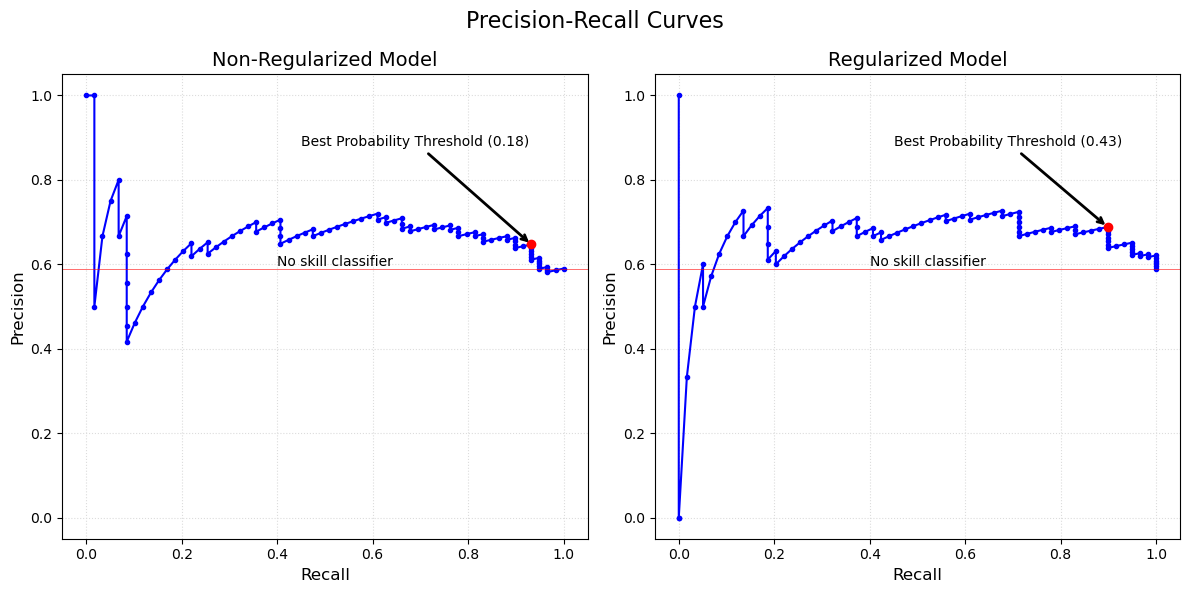

In [34]:
fig, ax_list = plt.subplots(1, 2, figsize=(12,6))
ax1 = ax_list[0]
ax1.plot(recall, precision, marker='.', color='blue')
ax1.axhline(y=y_test[y_test==1].sum().tolist()[0]/len(y_test), color='red', lw=0.4, ls='-')
ax1.annotate('No skill classifier', xy=(0.4,(y_test[y_test==1].sum()/len(y_test))+0.005))
ax1.set_title('Non-Regularized Model', fontsize=14)
ax1.set_xlabel('Recall', fontsize=12)
ax1.set_ylabel('Precision',fontsize=12)
ax1.set_ylim(-0.05, 1.05)
ax1.grid(True, ls= ':', linewidth=0.8, color='gainsboro')
ax1.plot(recall[best_f1_idx], precision[best_f1_idx], marker='o', color='red')
ax1.annotate('Best Probability Threshold (0.18)',
            xy=(recall[best_f1_idx], precision[best_f1_idx]),
            xytext=(0.45,0.88),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black', lw=2))


ax2 = ax_list[1]
ax2.plot(reg_recall, reg_precision, marker='.', color='blue')
ax2.axhline(y=y_test[y_test==1].sum().tolist()[0]/len(y_test), color='red', lw=0.4, ls='-')
ax2.annotate('No skill classifier', xy=(0.4,(y_test[y_test==1].sum()/len(y_test))+0.005))
ax2.set_title('Regularized Model', fontsize=14)
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision',fontsize=12)
ax2.grid(True, ls= ':', linewidth=0.8, color='gainsboro')
ax2.plot(reg_recall[reg_best_f1_idx], reg_precision[reg_best_f1_idx], marker='o', color='red')
ax2.annotate('Best Probability Threshold (0.43)',
            xy=(reg_recall[reg_best_f1_idx], reg_precision[reg_best_f1_idx]),
            xytext=(0.45,0.88),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='black', lw=2))

plt.suptitle('Precision-Recall Curves', fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
ypred_class_2 = (ypred >= pr_thresholds[best_f1_idx]).astype('int')

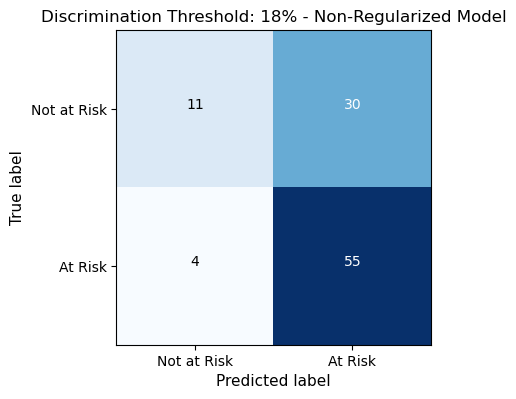

In [36]:
rnn_cm_2 = confusion_matrix(y_test, ypred_class_2, labels=[0,1])
plt.figure(figsize=(4.5,4.5))
plot_confusion_matrix(rnn_cm_2, classes=['Not at Risk', 'At Risk'],
                      title='Discrimination Threshold: 18% - Non-Regularized Model')
plt.show()

In [37]:
print('Discrimination Threshold: 18% - Non-Regularized Model Classification Report')
print(classification_report(y_test, ypred_class_2, labels=[0,1], target_names=['Not at Risk', 'At Risk']))

Discrimination Threshold: 18% - Non-Regularized Model Classification Report
              precision    recall  f1-score   support

 Not at Risk       0.73      0.27      0.39        41
     At Risk       0.65      0.93      0.76        59

    accuracy                           0.66       100
   macro avg       0.69      0.60      0.58       100
weighted avg       0.68      0.66      0.61       100



In [38]:
print('Discrimination Threshold: 54% - Regularized Model Classification Report')
print(classification_report(y_test, reg_ypred_class_1, labels=[0,1], target_names=['Not at Risk', 'At Risk']))

Discrimination Threshold: 54% - Regularized Model Classification Report
              precision    recall  f1-score   support

 Not at Risk       0.60      0.61      0.60        41
     At Risk       0.72      0.71      0.72        59

    accuracy                           0.67       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.67      0.67      0.67       100



In [39]:
reg_ypred_class_2 = (reg_ypred >= reg_pr_thresholds[reg_best_f1_idx]).astype('int')

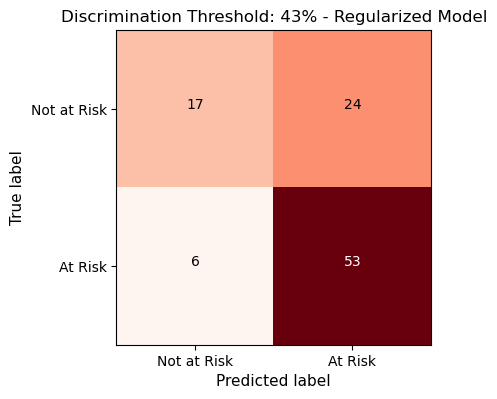

In [40]:
reg_rnn_cm_2 = confusion_matrix(y_test, reg_ypred_class_2, labels=[0,1])
plt.figure(figsize=(4.5,4.5))
plot_confusion_matrix(reg_rnn_cm_2, classes=['Not at Risk', 'At Risk'],
                      title='Discrimination Threshold: 43% - Regularized Model', cmap=plt.cm.Reds)
plt.show()

In [41]:
print('Discrimination Threshold: 43% - Regularized Model Classification Report')
print(classification_report(y_test, reg_ypred_class_2, labels=[0,1], target_names=['Not at Risk', 'At Risk']))

Discrimination Threshold: 43% - Regularized Model Classification Report
              precision    recall  f1-score   support

 Not at Risk       0.74      0.41      0.53        41
     At Risk       0.69      0.90      0.78        59

    accuracy                           0.70       100
   macro avg       0.71      0.66      0.66       100
weighted avg       0.71      0.70      0.68       100



Results:
- Setting a threshold as low as 18% (that is making it very easy for the model to predict the positive class), not surprisingly, increased massively the model sensitivity (up to 93%), but the specificity, consequently, fell down to a very low 27%. The precision of the positive class predictions also fell to 65%. Overall the model performs very well in predicting almost every true positive (the users "At-Risk") correctly, but the model exactness suffered, leading to the lowest F1 Score so far: 61%, calculated as the weighted average of each class F1 Score, and 58%, as the macro average of each class F1 Score.
- **Setting a decision threshold to 43% produced the best model** in terms of Accuracy (70%), average Precision (71%) as well as in terms of trade off between model's sensitivity and specificity, with the greatest F1 Score: 68% (calculated as the weighted average of each class F1 Score).

---

## Discussion

- Increased accuracy by 5%
- discuss why this is the best model
- 9 out of 10 users at risk can be corrrectly classified for targeted intervention
- 3 out of 10 users predicted as at risk are not at risk
- different hyperparameters, architecture, and regulariztion (maybe conclusion)
- No increase model complexity (maybe conclusion)
- recap of the model (emebeddings, regularization, threshold) - maybe this in conclusion
- WE NEED MORE DATA

Extras:
1. can I do cross validation / hyperparameters tuning with deep learnig models: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/#:~:text=By%20setting%20the%20n_jobs%20argument,for%20each%20combination%20of%20parameters.